# Post Training Quantization Weight Distribution

In this post, we are going to explore Post Training Quantization (PTQ) in more detail. In particular we will use Python to get a sense of what is going on during quantization (effectively peeking under the hood of TensorFlow). We will also visualize the weight distributions to gain intuition for why quantization is often so successful (hint: the weights are often closely clustered around 0). This is the summary of lecture "Applications of TinyML" from edX.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, edX, Deep_Learning, Tensorflow, tinyML]
- image: 

In [3]:
import numpy as np
from pprint import pprint
import re
import sys
import logging
import pathlib

import tensorflow as tf
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 10)
logging.getLogger('tensorflow').setLevel(logging.DEBUG)

print('Tensorflow v' + tf.__version__)

Tensorflow v2.3.1


## Exploring Post Training Quantization Algorithms in Python

Let us assume we have a weight array of size (256, 256).

In [4]:
weights = np.random.randn(256, 256)

In Post Training Quantization, we map the 32-bit floating point numbers to 8-bit integers. To do this, we need to find a very important value, the ***scale***. The ***scale*** value is used to convert numbers back and forth between the various representations. For example,  32-bit floating point numbers can be contructed from 8-bit Integers by the following formula:

$$ FP32\_Reconstructed\_Value = Scale \times Int8\_value $$

![ptq](image/ptq.png)

To make sure we can cover the complete weight distribution, the scale value needs to take into accound the full range of weight values which we can computer using the following formula. The denominator is 256 because that is the range of values that can be represented using 8-bits ($2^8 = 256$).

$$ scale = \frac{max(weights) - min(weights)}{256} $$

Now lets code this up!

We can then use this function to quantize our weights and then reconstruct them back to floating point format. We can then see what kinds of errors are introduced by this process. Our hope is that the errors in general are small showing that this process does a good job representing our weights in a more compact format. **In general if our scale is smaller it is more likely to have smaller errors as we are not lumping as many numbers into the same bin.**

In [5]:
def quantizeAndReconstruct(weights):
    """
    @param weights:np.ndarray
    
    This function computes the scale value to map fp32 values to int8. The function returns a weight matrix in fp32, 
    that is representable using 8-bits
    """
    
    # Compute the range of the weight
    max_weight = np.max(weights)
    min_weight = np.min(weights)
    range = max_weight - min_weight
    
    max_int8 = 2 ** 8
    
    # Compute the scale
    scale = range / max_int8
    
    # Compute the midpoint
    midpoint = np.mean([max_weight, min_weight])
    
    # Next, we need to map the real fp32 values to the integers. For this, we make use of the computed scale. 
    # By diving the weight matrix with the scale, the weight matrix has a range between (-128, 127). 
    # Now, we can simply round the full precision numbers to the closest integers.
    centered_weights = weights - midpoint
    quantized_weights = np.rint(centered_weights / scale)
    
    reconstructed_weights = scale * quantized_weights + midpoint
    return reconstructed_weights

In [6]:
reconstructed_weights = quantizeAndReconstruct(weights)
print('Original weight matrix\n', weights)
print('Weight Matrix after reconstruction\n', reconstructed_weights)

errors = reconstructed_weights - weights
max_error = np.max(errors)
print('Max Error: ', max_error)
print(reconstructed_weights.shape)

Original weight matrix
 [[-0.20651395  0.63304082 -0.62394744 ...  0.53406976  0.10831321
   1.59257432]
 [-0.75312965 -0.46266008  0.09700057 ... -1.29137176  0.17945537
   0.77350219]
 [-0.64099055  0.23122771 -1.62409353 ...  0.68012391 -2.99812588
   0.971169  ]
 ...
 [-1.87559052 -0.61450203 -2.58038952 ... -1.08839651 -0.04834415
  -1.57813424]
 [ 1.00904328 -0.22549421  0.2668497  ... -0.67688187  1.38666928
   1.54156459]
 [-0.41693204  1.96688186 -0.410589   ... -0.14860571  1.8539901
  -0.41257967]]
Weight Matrix after reconstruction
 [[-0.20337133  0.62585975 -0.63457149 ...  0.52635202  0.09515186
   1.5877678 ]
 [-0.76724847 -0.46872528  0.09515186 ... -1.29795636  0.19465959
   0.75853672]
 [-0.63457149  0.22782883 -1.62964879 ...  0.69219823 -2.98958776
   0.95755218]
 ...
 [-1.86183349 -0.60140225 -2.59155684 ... -1.0989409  -0.03752512
  -1.5633103 ]
 [ 1.02389066 -0.23654058  0.26099807 ... -0.66774074  1.38875234
   1.55459855]
 [-0.40238679  1.95262947 -0.40238679 .

The quantized representation should not have more than 256 unique floating numbers, lets do a sanity check.

In [7]:
np.unique(quantizeAndReconstruct(weights)).shape

(230,)

## Exploring Post Training Quantization using TFLite

Now that we know how PTQ works under the hood, lets move over to seeing the actual benefits in terms of memory and speed. Since in numpy, we were representing our final weight matrix in full precision, the memory occupied was still the same. However, in TFLite, we only store the matrix in an 8-bit format. As you have seen in previous Colabs, this can lead to a decrease in size of the model by a factor of up to 4!

> Note: We however do not save a perfect factor of 4 in total memory usage as we now also have to store the scale (and potentially other factors needed to properly convert the numbers).

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Reshape, Conv2D, MaxPooling2D, Flatten, Dense

# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture
model = Sequential([
    InputLayer(input_shape=(28, 28)),
    Reshape(target_shape=(28, 28, 1)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=1, validation_data=(test_images, test_labels))

1875/1875 [==============================] - 3s 1ms/step - loss: 0.1802 - accuracy: 0.9475 - val_loss: 0.0858 - val_accuracy: 0.9721


In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_models_dir = pathlib.Path('./mnist_tflite_models/')
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\kcsgo\AppData\Local\Temp\tmputmwc95s\assets


438052

In [12]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_quant_model_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_quant_model_file.write_bytes(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\kcsgo\AppData\Local\Temp\tmpk6bzg289\assets


INFO:tensorflow:Assets written to: C:\Users\kcsgo\AppData\Local\Temp\tmpk6bzg289\assets


113792

In [13]:
!dir mnist_tflite_models

 G 드라이브의 볼륨: work
 볼륨 일련 번호: 70B7-DC20

 G:\git\edx\Harvard-TinyML2\mnist_tflite_models 디렉터리

2020-12-29  오후 03:29    <DIR>          .
2020-12-29  오후 03:29    <DIR>          ..
2020-12-29  오후 03:28           438,052 mnist_model.tflite
2020-12-29  오후 03:29           113,792 mnist_model_quant.tflite
               2개 파일             551,844 바이트
               2개 디렉터리  2,287,156,101,120 바이트 남음


**Notice the size difference - the quantized model is smaller by a factor of ~4 as expected**

## Software Installation to Inspect TFLite Models

Before we can inspect TF Lite files in detail we need to build and install software to read the file format. First we’ll build and install the Flatbuffer compiler, which takes in a schema definition and outputs Python files to read files with that format.

**Note: This will take a few minutes to run.**

```bash
%%bash

cd /content/
git clone https://github.com/google/flatbuffers
cd flatbuffers
cmake -G "Unix Makefiles" -DCMAKE_BUILD_TYPE=Release
make
cp flatc /usr/local/bin/
cd /content/
git clone --depth 1 https://github.com/tensorflow/tensorflow
flatc --python --gen-object-api tensorflow/tensorflow/lite/schema/schema_v3.fbs
pip install flatbuffers
```

> Note: I compiled it on windows on Linux, and move it here.

In [20]:
sys.path.append('./tflite')
import Model

we define some utility functions that will help us convert the model into a dictionary that's easy to work with in Python.

In [21]:
def CamelCaseToSnakeCase(camel_case_input):
    """Converts an identifier in CamelCase to snake_case."""
    s1 = re.sub("(.)([A-Z][a-z]+)", r"\1_\2", camel_case_input)
    return re.sub("([a-z0-9])([A-Z])", r"\1_\2", s1).lower()

def FlatbufferToDict(fb, attribute_name=None):
    """Converts a hierarchy of FB objects into a nested dict."""
    if hasattr(fb, "__dict__"):
        result = {}
        for attribute_name in dir(fb):
            attribute = fb.__getattribute__(attribute_name)
            if not callable(attribute) and attribute_name[0] != "_":
                snake_name = CamelCaseToSnakeCase(attribute_name)
                result[snake_name] = FlatbufferToDict(attribute, snake_name)
        return result

    elif isinstance(fb, str):
        return fb
    
    elif attribute_name == "name" and fb is not None:
        result = ""
        for entry in fb:
            result += chr(FlatbufferToDict(entry))
        return result
    elif hasattr(fb, "__len__"):
        result = []
        for entry in fb:
            result.append(FlatbufferToDict(entry))
        return result
    else:
        return fb

def CreateDictFromFlatbuffer(buffer_data):
    model_obj = Model.Model.GetRootAsModel(buffer_data, 0)
    model = Model.ModelT.InitFromObj(model_obj)
    return FlatbufferToDict(model)

## Visualizing TFLite model weight distributions

This example uses the Inception v3 model, dating back to 2015, but you can replace it with your own file by updating the variables. To load in any TFLite model.

In [22]:
MODEL_FILE_NAME = 'inceptionv3_non_slim_2015.tflite'
with open(MODEL_FILE_NAME, 'rb') as file:
    model_data = file.read()

Once we have the raw bytes of the file, we need to convert them into an understandable form. The utility functions and Python schema code we generated earlier will help us create a dictionary holding the file contents in a structured form. 

**Note: since it's a large file, this will take several minutes to run.**

In [23]:
model_dict = CreateDictFromFlatbuffer(model_data)

Now we have the model file in a dictionary, we can examine its contents using standard Python commands. In this case we're interested in examining the tensors (arrays of values) in the first subgraph, so we're printing them out.

In [24]:
pprint(model_dict['subgraphs'][0]['tensors'])

[{'buffer': 206,
  'name': 'Mul',
  'quantization': {'max': [255.0],
                   'min': [0.0],
                   'scale': None,
                   'zero_point': None},
  'shape': [1, 299, 299, 3],
  'type': 0},
 {'buffer': 260,
  'name': 'conv',
  'quantization': {'max': None, 'min': None, 'scale': None, 'zero_point': None},
  'shape': [1, 149, 149, 32],
  'type': 0},
 {'buffer': 71,
  'name': 'conv/Conv2D_bias',
  'quantization': {'max': None, 'min': None, 'scale': None, 'zero_point': None},
  'shape': [32],
  'type': 0},
 {'buffer': 186,
  'name': 'conv/conv2d_params',
  'quantization': {'max': None, 'min': None, 'scale': None, 'zero_point': None},
  'shape': [32, 3, 3, 3],
  'type': 0},
 {'buffer': 261,
  'name': 'conv_1',
  'quantization': {'max': None, 'min': None, 'scale': None, 'zero_point': None},
  'shape': [1, 147, 147, 32],
  'type': 0},
 {'buffer': 70,
  'name': 'conv_1/Conv2D_bias',
  'quantization': {'max': None, 'min': None, 'scale': None, 'zero_point': None},
  

Let's inspect the weight parameters of a typical convolution layer, so looking at the output above we can see that the tensor with the name 'Conv2D' has a buffer index of 212. This index points to where the raw bytes for the trained weights are stored. From the tensor properties I can see its type is '0', which [corresponds to a type of float32](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/schema/schema_v3.fbs#L30).

This means we have to cast the bytes into a numpy array using the frombuffer() function.

In [25]:
params_bytes = bytearray(model_dict['buffers'][212]['data'])
params = np.frombuffer(params_bytes, dtype=np.float32)

With the weights loaded into a numpy array, we can now use all the standard functionality to analyze them. To start, let's print out the minimum and maximum values to understand the range.

In [26]:
params.min()

-0.96512187

In [27]:
params.max()

1.0061601

This gives us the total range of the weight values, but how are those parameters distributed across that range?

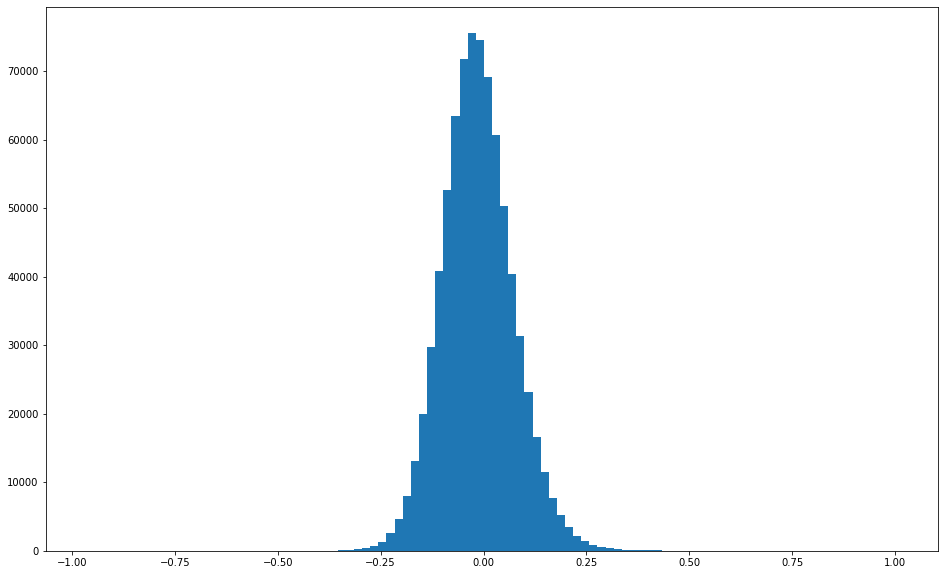

In [28]:
plt.figure()
plt.hist(params, bins=100)
plt.show()

**This shows a distribution that's heavily concentrated around zero. This explains why quantization can work quite well. With values so concentrated around zero, our scale can be quite small and therefore it is much easier to do an accurate reconstruction as we do not need to represent a large number of values!**

## More Models to Explore

In [29]:
TEXT_CLASSIFICATION_MODEL_FILE_NAME = "text_classification_v2.tflite"
POSE_ESTIMATION_MODEL_FILE_NAME = "posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite"

with open(TEXT_CLASSIFICATION_MODEL_FILE_NAME, 'rb') as file:
    text_model_data = file.read()

with open(POSE_ESTIMATION_MODEL_FILE_NAME, 'rb') as file:
    pose_model_data = file.read()

In [30]:
def aggregate_all_weights(buffers):
    weights = []
    for i in range(len(buffers)):
        raw_data = buffers[i]['data']
        if raw_data is not None:
            param_bytes = bytearray(raw_data)
            params = np.frombuffer(param_bytes, dtype=np.float32)
            weights.extend(params.flatten().tolist())

    weights = np.asarray(weights)
    weights = weights[weights<50]
    weights = weights[weights>-50]

    return weights

Lets plot the distribution of the Text Classification Model in log scale


C:\Users\kcsgo\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


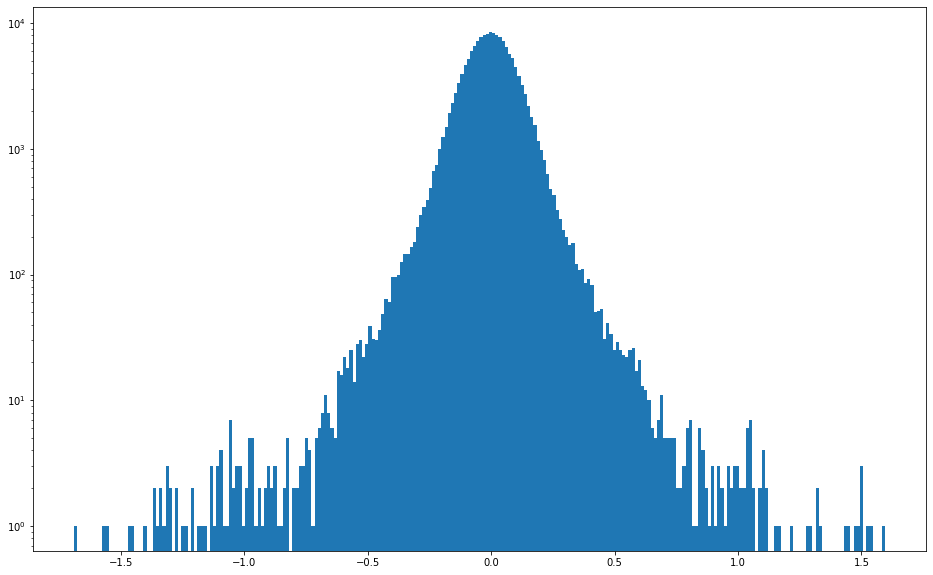

In [31]:
model_dict_temp = CreateDictFromFlatbuffer(text_model_data)
weights = aggregate_all_weights(model_dict_temp['buffers'])

plt.hist(weights, 256, log=True)
plt.show()

Let's plot the distribution of the Pose Net Model in log scale

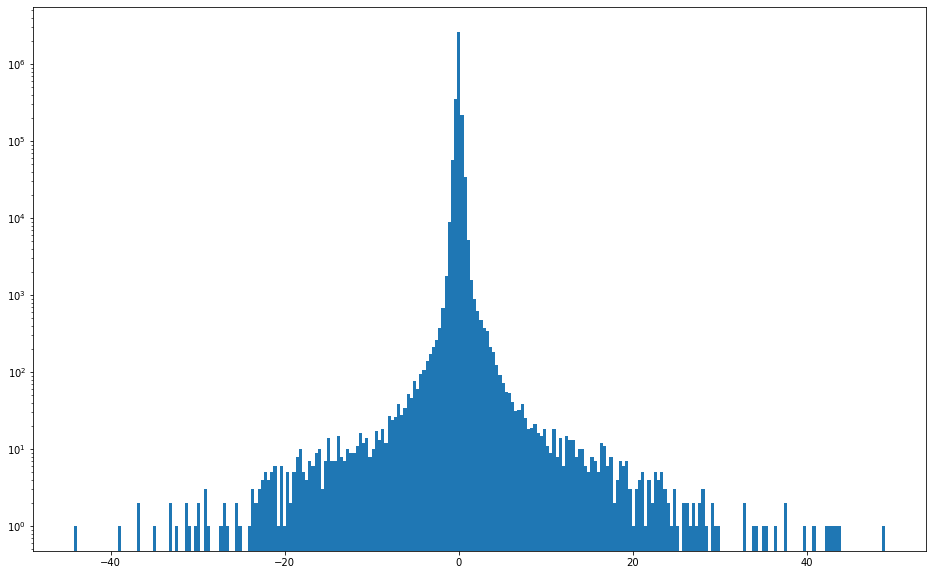

In [32]:
model_dict_temp = CreateDictFromFlatbuffer(pose_model_data)
weights = aggregate_all_weights(model_dict_temp['buffers'][:-1])

plt.hist(weights, bins=256, log=True)
plt.show()

**Again we find that most model weights are closely packed around 0.**